
# Logistic Regression

In [1]:
# load these packages

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml import feature, regression, evaluation, Pipeline, clustering, classification
from pyspark.sql import functions as fn, Row, SparkSession
from pyspark.sql.functions import col, expr, when
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import sys
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext



In [2]:
!{sys.executable} -m pip install koalas

In [3]:
import databricks.koalas as ks

In [4]:
#read in the netflow data
netflow_labeled = spark.read.csv('netflow_labeled.csv', header=True, inferSchema=True)

In [5]:
from pyspark.sql.types import DoubleType
netflow_labeled = netflow_labeled.withColumn("anomalous", netflow_labeled["anomalous"].cast(DoubleType()))
#netflow_labeled = joindf.withColumn("anomalous", joindf["show"].cast(DoubleType()))

In [6]:
netflow_labeled.dtypes

[('_c0', 'int'),
 ('dest_ip', 'string'),
 ('dest_port', 'int'),
 ('src_ip', 'string'),
 ('src_port', 'int'),
 ('app', 'string'),
 ('bytes', 'bigint'),
 ('bytes_in', 'int'),
 ('bytes_out', 'int'),
 ('timestamp', 'timestamp'),
 ('endtime', 'timestamp'),
 ('z_score', 'double'),
 ('large_upload', 'int'),
 ('private', 'double'),
 ('date', 'timestamp'),
 ('hour', 'int'),
 ('second', 'int'),
 ('bad_traffic', 'int'),
 ('bad_ports', 'int'),
 ('z_score_alpha', 'int'),
 ('bad_ip', 'int'),
 ('kmeans_feat', 'int'),
 ('anomalous', 'double')]

# IP Address String to Integer

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, IntegerType, LongType
import ipaddress
import math

def IP_to_Int(ip):
    address = int(ipaddress.IPv4Address(ip))
    return address

z_udf = udf(lambda z: IP_to_Int(z), LongType())

In [14]:
netflow_labeled = netflow_labeled.select('*', z_udf(col("dest_ip")).alias('dest_ip_int'))
netflow_index = netflow_labeled.select('*', z_udf("src_ip").alias('src_ip_int'))

In [15]:
netflow_index.show(2, False)

+---+------------+---------+----------+--------+---------+-------+--------+---------+-----------------------+-----------------------+------------------+------------+-------+-------------------+----+------+-----------+---------+-------------+------+-----------+---------+-----------+----------+
|_c0|dest_ip     |dest_port|src_ip    |src_port|app      |bytes  |bytes_in|bytes_out|timestamp              |endtime                |z_score           |large_upload|private|date               |hour|second|bad_traffic|bad_ports|z_score_alpha|bad_ip|kmeans_feat|anomalous|dest_ip_int|src_ip_int|
+---+------------+---------+----------+--------+---------+-------+--------+---------+-----------------------+-----------------------+------------------+------------+-------+-------------------+----+------+-----------+---------+-------------+------+-----------+---------+-----------+----------+
|0  |40.97.128.34|443      |10.0.2.109|58107   |office365|1441608|167497  |1274111  |2017-07-31 14:46:43.264|2017-08-0

# Split the dataframe with replacements

#### Split the data 

In [16]:
#convert the dataframe to koalas... take 3 random samples
training_df =  netflow_index.to_koalas().sample(frac=0.7, replace=True)
validation_df = netflow_index.to_koalas().sample(frac=0.3, replace=True)
testing_df = netflow_index.to_koalas().sample(frac=0.1, replace=True)

In [17]:
print("# points in training: ", len(training_df))
print("# points in validation: ", len(validation_df))
print("# points in testing: ", len(testing_df))

# points in training:  1426022
# points in validation:  611692
# points in testing:  204438


In [18]:
training_df = training_df.to_spark()
validation_df = validation_df.to_spark()
testing_df = testing_df.to_spark()

# Initial base_model Logitic Regression

$$
p(anomolous = 1) = f(\text{dest_ip},  \text{private}, \text{dest_port}, \text{src_ip}, \text{src_port}, \text{bytes}, \text{hour})
$$

In [19]:
print(netflow_index.columns)

['_c0', 'dest_ip', 'dest_port', 'src_ip', 'src_port', 'app', 'bytes', 'bytes_in', 'bytes_out', 'timestamp', 'endtime', 'z_score', 'large_upload', 'private', 'date', 'hour', 'second', 'bad_traffic', 'bad_ports', 'z_score_alpha', 'bad_ip', 'kmeans_feat', 'anomalous', 'dest_ip_int', 'src_ip_int']


In [20]:
base_model = Pipeline(stages=[feature.VectorAssembler(inputCols=['bytes', 'hour', 'private', 'dest_ip_int', 'dest_port', 'src_ip_int', 'src_port'],outputCol='features'),
                          classification.LogisticRegression(labelCol='anomalous', featuresCol='features')])

#### Fit the training data into model 1

In [21]:
base_model_fitted = base_model.fit(training_df)

### ROC the curve

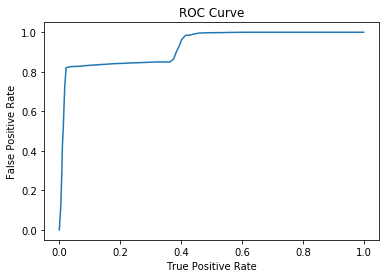

Training set areaUnderROC: 0.9274086991382606


In [22]:
trainingSummary = base_model_fitted.stages[1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Precision and Recall

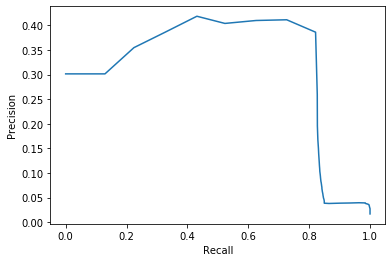

In [23]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Get the AUC for the base_model

#### Set the binary classifier to evaluate the labeled colun

In [24]:
evaluator = BinaryClassificationEvaluator(labelCol='anomalous', metricName='areaUnderROC')

#### Evaluate the model with the validation data frame

In [25]:
#evaluated with validation dataframe
evaluator.evaluate(base_model_fitted.transform(validation_df))

0.9286788855920136

#### Evaluate the model with the testing dataframe

In [26]:
#evaluated with testing dataframe
evaluator.evaluate(base_model_fitted.transform(testing_df))

0.9261810743521394

#### get the average of the labeled column

In [27]:
netflow_index.select(fn.avg('anomalous')).show()

+--------------------+
|      avg(anomalous)|
+--------------------+
|0.016817993259645996|
+--------------------+



### Get the f1_score, accuracy measure

#### Use the multiclassClassification evaluator for f1_score

In [28]:
f1_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='anomalous', metricName='f1')

##### f1 metric on validation dataframe with base_model_fitted

In [29]:
f1_evaluator.evaluate(base_model_fitted.transform(validation_df))

0.9785668015956449

##### f1 metric on testing dataframe with base_model_fitted

In [30]:
f1_evaluator.evaluate(base_model_fitted.transform(testing_df))

0.9778923664004434

#### Use the multiclassClassification evaluator accuracy

In [31]:
accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='anomalous', metricName='accuracy')

##### accuracy metric on validation dataframe with base_model_fitted

In [32]:
accuracy_evaluator.evaluate(base_model_fitted.transform(validation_df))

0.9840099265643494

##### accuracy metric on testing dataframe with base_model_fitted

In [33]:
accuracy_evaluator.evaluate(base_model_fitted.transform(testing_df))

0.9834962189025523

### Calculate RMSE for base_model with regressionEvaluator

#### Set metricName = 'rmse'

In [34]:
rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='anomalous', metricName='rmse')

##### rmse for the validation dataframe on the base_model_fitted

In [35]:
rmse_evaluator.evaluate(base_model_fitted.transform(validation_df))

0.12645186212804704

##### rmse for the testing dataframe on the base_model_fitted

In [36]:
rmse_evaluator.evaluate(base_model_fitted.transform(testing_df))

0.12846704284542257

## Obtain the coefficients by using LogisticRegressionModel's attributes

#### We can obtain the coefficients by using LogisticRegressionModel’s attributes.

In [38]:
base_model_fitted.stages[1].coefficients

DenseVector([0.0, -0.1892, 22.761, -0.0, 0.0, -0.0, -0.0])

In [41]:
coeff = np.sort(base_model_fitted.stages[1].coefficients)


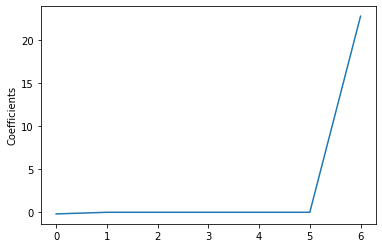

In [42]:
plt.plot(coeff)
plt.ylabel('Coefficients')
plt.show()

In [43]:
# Evaluate on Training Set
predictionAndLabels = base_model_fitted.transform(testing_df)   

In [44]:
def evaluate(predictionAndLabels):
    log = {}

    # Show Validation Score (AUROC)
    evaluator = BinaryClassificationEvaluator(labelCol='anomalous', metricName='areaUnderROC')
    log['AUROC'] = "%f" % evaluator.evaluate(predictionAndLabels)    
    print("Area under ROC = {}".format(log['AUROC']))

    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(labelCol='anomalous', metricName='areaUnderPR')
    log['AUPR'] = "%f" % evaluator.evaluate(predictionAndLabels)
    print("Area under PR = {}".format(log['AUPR']))

    # Metrics
    predictionRDD = predictionAndLabels.select(['anomalous', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    print(metrics.confusionMatrix().toArray())

    # Overall statistics
    log['precision'] = "%s" % metrics.precision()
    log['recall'] = "%s" % metrics.recall()
    log['F1 Measure'] = "%s" % metrics.fMeasure()
    print("[Overall]\tprecision = %s | recall = %s | F1 Measure = %s" % \
            (log['precision'], log['recall'], log['F1 Measure']))

    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        log[label] = {}
        log[label]['precision'] = "%s" % metrics.precision(label)
        log[label]['recall'] = "%s" % metrics.recall(label)
        log[label]['F1 Measure'] = "%s" % metrics.fMeasure(label, 
                                                           beta=1.0)
        print("[Class %s]\tprecision = %s | recall = %s | F1 Measure = %s" \
                  % (label, log[label]['precision'], 
                    log[label]['recall'], log[label]['F1 Measure']))

    return log

In [45]:
log = evaluate(predictionAndLabels)

Area under ROC = 0.926181
Area under PR = 0.404957
[[200641.    239.]
 [  3135.    423.]]
[Overall]	precision = 0.9834962189025523 | recall = 0.9834962189025523 | F1 Measure = 0.9834962189025523
[Class 0.0]	precision = 0.9846154601130653 | recall = 0.998810234966149 | F1 Measure = 0.9916620536949904
[Class 1.0]	precision = 0.6389728096676737 | recall = 0.11888701517706576 | F1 Measure = 0.2004739336492891


#### Transform the training data to see predictions

In [ ]:
base_training_df = base_model_fitted.transform(training_df)

In [ ]:
base_training_df.count()

In [ ]:
base_training_df.where("prediction == 1").count()

In [ ]:
base_training_df.where("prediction == 1").show(10)

# Develop l3_model and test with L3 regularization

In [46]:
#create logistic regression l3 regularization model
#tfidf_pipeline.transform(sms_spam2_df)
lambda_par = 0.02
alpha_par = 0.2
lr = classification.LogisticRegression().\
        setLabelCol('anomalous').\
        setFeaturesCol('features').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

In [47]:
l3_model = Pipeline(stages=[feature.VectorAssembler(inputCols=['z_score_alpha', 'hour','private', 'dest_ip_int', 'dest_port', 'src_ip_int', 'src_port'],outputCol='features'),
                          lr])

#### Fit the training data into model 1

In [48]:
l3_model_fitted = l3_model.fit(training_df)

#### Set the binary classifier to evaluate the labeled colun

In [49]:
evaluator = BinaryClassificationEvaluator(labelCol='anomalous')

#### Evaluate the model with the validation data frame

In [50]:
#evaluated with validation dataframe
evaluator.evaluate(l3_model_fitted.transform(validation_df))

0.9014405604076476

#### Evaluate the model with the testing dataframe

In [51]:
#evaluated with testing dataframe
evaluator.evaluate(l3_model_fitted.transform(testing_df))

0.8988041466619496

In [52]:
# Evaluate on Training Set
predictionAndLabels = l3_model_fitted.transform(testing_df)   

In [53]:
evaluate(predictionAndLabels)

Area under ROC = 0.898804
Area under PR = 0.397126
[[200880.      0.]
 [  3196.    362.]]
[Overall]	precision = 0.9843668985218013 | recall = 0.9843668985218013 | F1 Measure = 0.9843668985218013
[Class 0.0]	precision = 0.9843391677610303 | recall = 1.0 | F1 Measure = 0.9921077845494326
[Class 1.0]	precision = 1.0 | recall = 0.1017425519955031 | F1 Measure = 0.18469387755102043


{'AUROC': '0.898804',
 'AUPR': '0.397126',
 'precision': '0.9843668985218013',
 'recall': '0.9843668985218013',
 'F1 Measure': '0.9843668985218013',
 0.0: {'precision': '0.9843391677610303',
  'recall': '1.0',
  'F1 Measure': '0.9921077845494326'},
 1.0: {'precision': '1.0',
  'recall': '0.1017425519955031',
  'F1 Measure': '0.18469387755102043'}}

# Decision Tree (d_tree)

#### Need to remove encoded values because they are to long for Decision Tree to bin

In [54]:
d_tree_model = Pipeline(stages=[feature.VectorAssembler(inputCols=['z_score_alpha', 'hour','private', 'dest_ip_int', 'dest_port', 'src_ip_int', 'src_port'],outputCol='features'),
                          DecisionTreeClassifier(featuresCol = 'features', labelCol = 'anomalous', maxDepth = 3)])

#### Fit the training data into d_tree model

In [55]:
d_tree_fitted = d_tree_model.fit(training_df)
predictions = d_tree_fitted.transform(validation_df)


In [56]:
predictions.where('prediction = 1').show(2)

+----+-------------+---------+------------+--------+-----+--------+--------+---------+--------------------+--------------------+-----------------+------------+-------+-------------------+----+------+-----------+---------+-------------+------+-----------+---------+-----------+----------+--------------------+-------------+-----------+----------+
| _c0|      dest_ip|dest_port|      src_ip|src_port|  app|   bytes|bytes_in|bytes_out|           timestamp|             endtime|          z_score|large_upload|private|               date|hour|second|bad_traffic|bad_ports|z_score_alpha|bad_ip|kmeans_feat|anomalous|dest_ip_int|src_ip_int|            features|rawPrediction|probability|prediction|
+----+-------------+---------+------------+--------+-----+--------+--------+---------+--------------------+--------------------+-----------------+------------+-------+-------------------+----+------+-----------+---------+-------------+------+-----------+---------+-----------+----------+--------------------+

In [57]:
print("Validation Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Validation Area Under ROC: 0.4515216543113539


In [58]:
# Evaluate on Training Set
predictionAndLabels = d_tree_fitted.transform(testing_df)   

In [59]:
evaluate(predictionAndLabels)

Area under ROC = 0.449129
Area under PR = 0.015749
[[200880.      0.]
 [  3196.    362.]]
[Overall]	precision = 0.9843668985218013 | recall = 0.9843668985218013 | F1 Measure = 0.9843668985218013
[Class 0.0]	precision = 0.9843391677610303 | recall = 1.0 | F1 Measure = 0.9921077845494326
[Class 1.0]	precision = 1.0 | recall = 0.1017425519955031 | F1 Measure = 0.18469387755102043


{'AUROC': '0.449129',
 'AUPR': '0.015749',
 'precision': '0.9843668985218013',
 'recall': '0.9843668985218013',
 'F1 Measure': '0.9843668985218013',
 0.0: {'precision': '0.9843391677610303',
  'recall': '1.0',
  'F1 Measure': '0.9921077845494326'},
 1.0: {'precision': '1.0',
  'recall': '0.1017425519955031',
  'F1 Measure': '0.18469387755102043'}}

# Random Forest

In [60]:
from pyspark.ml.classification import RandomForestClassifier


In [61]:
rf_model = Pipeline(stages=[feature.VectorAssembler(inputCols=['z_score_alpha', 'hour','private', 'dest_ip_int', 'dest_port', 'src_ip_int', 'src_port'],outputCol='features'),
                          RandomForestClassifier(featuresCol = 'features', labelCol = 'anomalous')])

In [62]:
rf_model_fitted = rf_model.fit(training_df)
predictions = rf_model_fitted.transform(validation_df)


In [ ]:
#AUC

In [63]:
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9843346416642715


In [64]:
# Evaluate on Training Set
predictionAndLabels = rf_model_fitted.transform(testing_df)   

In [65]:
evaluate(predictionAndLabels)

Area under ROC = 0.983981
Area under PR = 0.815503
[[2.00753e+05 1.27000e+02]
 [9.79000e+02 2.57900e+03]]
[Overall]	precision = 0.9945900468601727 | recall = 0.9945900468601727 | F1 Measure = 0.9945900468601727
[Class 0.0]	precision = 0.9951470267483592 | recall = 0.9993677817602549 | F1 Measure = 0.9972529383128174
[Class 1.0]	precision = 0.9530672579453068 | recall = 0.7248454187745925 | F1 Measure = 0.8234355044699873


{'AUROC': '0.983981',
 'AUPR': '0.815503',
 'precision': '0.9945900468601727',
 'recall': '0.9945900468601727',
 'F1 Measure': '0.9945900468601727',
 0.0: {'precision': '0.9951470267483592',
  'recall': '0.9993677817602549',
  'F1 Measure': '0.9972529383128174'},
 1.0: {'precision': '0.9530672579453068',
  'recall': '0.7248454187745925',
  'F1 Measure': '0.8234355044699873'}}

### ROC the curve for Random Forest

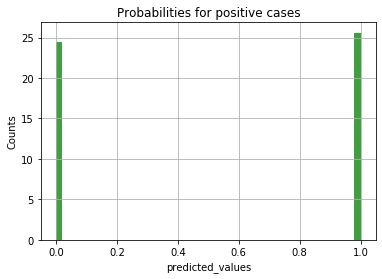

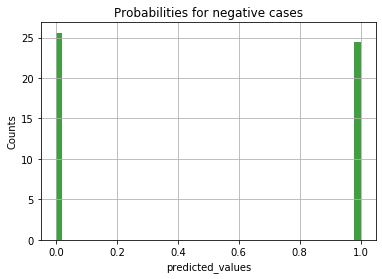

In [75]:
all_probs = predictionAndLabels.select("probability").collect()
pos_probs = [i[0][0] for i in all_probs]
neg_probs = [i[0][1] for i in all_probs]
 
from matplotlib import pyplot as plt
%matplotlib inline
 
# pos
plt.hist(pos_probs, 50, density=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for positive cases')
plt.grid(True)
plt.show()
 
# neg
plt.hist(neg_probs, 50, density=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for negative cases')
plt.grid(True)
plt.show()

## Naive Bayes model

#### Naive Bayes classifier is one of the most straightforward multiclass classification algorithms, which can be applied to the multiclass classification task, with the assumption of independence between every pair of features. It can be trained very efficiently. For this algorithm, we will use the same previously prepared dataframe as in the previous models.

In [66]:
from pyspark.ml.classification import NaiveBayes

In [67]:
nb_pipe_model = Pipeline(stages=[feature.VectorAssembler(inputCols=['z_score_alpha', 'hour','private', 'dest_ip_int', 'dest_port', 'src_ip_int', 'src_port'],outputCol='features'),
                          NaiveBayes(labelCol="anomalous", featuresCol="features", smoothing=1.0, modelType="multinomial")])

In [68]:
nb_model_fitted = nb_pipe_model.fit(training_df)

In [69]:
predictions = nb_model_fitted.transform(validation_df)

In [70]:
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5588358902024755


In [71]:
# Evaluate on Training Set
predictionAndLabels = nb_model_fitted.transform(testing_df)   

In [72]:
evaluate(predictionAndLabels)

Area under ROC = 0.554569
Area under PR = 0.019126
[[101387.  99493.]
 [  3209.    349.]]
[Overall]	precision = 0.4976374255275438 | recall = 0.4976374255275438 | F1 Measure = 0.4976374255275438
[Class 0.0]	precision = 0.9693200504799419 | recall = 0.5047142572680207 | F1 Measure = 0.6637968285560895
[Class 1.0]	precision = 0.003495522926223433 | recall = 0.09808881394041596 | F1 Measure = 0.006750483558994198


{'AUROC': '0.554569',
 'AUPR': '0.019126',
 'precision': '0.4976374255275438',
 'recall': '0.4976374255275438',
 'F1 Measure': '0.4976374255275438',
 0.0: {'precision': '0.9693200504799419',
  'recall': '0.5047142572680207',
  'F1 Measure': '0.6637968285560895'},
 1.0: {'precision': '0.003495522926223433',
  'recall': '0.09808881394041596',
  'F1 Measure': '0.006750483558994198'}}

# Read in Testing Dataset

In [7]:
#read in the netflow data
netflow_v1 = spark.read.csv('netflowv1_labeled.csv', header=True, inferSchema=True)

In [8]:
netflow_v1 = netflow_v1.to_koalas()

In [9]:
netflow_v1.head()

,bytes,src_ip,src_port,bytes_in,dest_ip,dest_port,bytes_out,bad_ports,large_upload,z_score,z_score_alpha,bad_ip,anomalous,timestart,timeend,hour,minute,private,dest_ip_int,src_ip_int
0,5978,192.168.228.105,37119,2463,192.168.224.78,8089,3515,0,0,-0.037824,0,0,0,2016-08-28T235857,2016-08-28T235857,23,58,0,3232292942,3232293993
1,5377,192.168.225.88,47224,2092,192.168.228.88,8089,3285,0,0,-0.038352,0,0,0,2016-08-28T235854,2016-08-28T235854,23,58,0,3232293976,3232293208
2,9333,192.168.225.234,25022,1579,23.203.184.161,443,7754,0,0,-0.034875,0,0,0,2016-08-28T235852,2016-08-28T235852,23,58,1,399227041,3232293354
3,6723,192.168.228.69,55949,2994,192.168.229.165,8089,3729,0,0,-0.037169,0,0,0,2016-08-28T235851,2016-08-28T235851,23,58,0,3232294309,3232293957
4,6010,192.168.226.142,3322,2463,192.168.224.47,8089,3547,0,0,-0.037795,0,0,0,2016-08-28T235849,2016-08-28T235849,23,58,0,3232292911,3232293518


In [10]:
netflow_v1['anomalous'] = netflow_v1['anomalous'].astype("double")

In [11]:
netflowV1 = netflow_v1.to_spark()

In [12]:
netflowV1.dtypes

[('bytes', 'int'),
 ('src_ip', 'string'),
 ('src_port', 'int'),
 ('bytes_in', 'int'),
 ('dest_ip', 'string'),
 ('dest_port', 'int'),
 ('bytes_out', 'int'),
 ('bad_ports', 'int'),
 ('large_upload', 'int'),
 ('z_score', 'double'),
 ('z_score_alpha', 'int'),
 ('bad_ip', 'int'),
 ('anomalous', 'double'),
 ('timestart', 'string'),
 ('timeend', 'string'),
 ('hour', 'int'),
 ('minute', 'int'),
 ('private', 'int'),
 ('dest_ip_int', 'bigint'),
 ('src_ip_int', 'bigint')]

# Need to make the destination and sources addresses and ports integers before applying the test model

### Use the udf for ip address to int

In [179]:
netflowV1 = netflowV1.select('*', z_udf(col("dest_ip")).alias('dest_ip_int'))
netflowV1 = netflowV1.select('*', z_udf("src_ip").alias('src_ip_int'))

In [181]:
print(netflowV1.dtypes)

[('endtime', 'string'), ('timestamp', 'string'), ('bytes', 'int'), ('src_ip', 'string'), ('src_port', 'int'), ('bytes_in', 'int'), ('dest_ip', 'string'), ('dest_port', 'int'), ('bytes_out', 'int'), ('bad_ports', 'int'), ('large_upload', 'int'), ('z_score', 'double'), ('z_score_alpha', 'int'), ('bad_ip', 'int'), ('anomalous', 'int'), ('timestart', 'string'), ('timeend', 'string'), ('hour', 'int'), ('minute', 'int'), ('private', 'double'), ('dest_ip_int', 'bigint'), ('src_ip_int', 'bigint')]


In [184]:
base_model = Pipeline(stages=[feature.VectorAssembler(inputCols=['z_score_alpha', 'hour','private', 'dest_ip_int', 'dest_port', 'src_ip_int', 'src_port'],outputCol='features'),
                          classification.LogisticRegression(labelCol='anomalous', featuresCol='features')])

#### Fit the training data into model 1

In [236]:
base_model_fitted = base_model.fit(training_df)

#### Evaluate the model with the validation data frame

In [198]:
#evaluated with validation dataframe
evaluator.evaluate(base_model_fitted.transform(validation_df))

0.9263853819535347

#### Evaluate model with the bots_v1 test set

In [237]:
#evaluated with validation dataframe
evaluator.evaluate(base_model_fitted.transform(netflowV1))

0.9030388530018225

In [ ]:
# Evaluate on Training Set
predictionAndLabels = base_model_fitted.transform(netflowV1)  

# Generate the Metrics for the Best Model

In [238]:
#run the evaluate function to get measurements
evaluate(predictionAndLabels)

Area under ROC = 0.903039
Area under PR = 0.011624
[[6.34924e+05 0.00000e+00]
 [1.08000e+03 1.00000e+00]]
[Overall]	precision = 0.9983019001422945 | recall = 0.9983019001422945 | F1 Measure = 0.9983019001422945
[Class 0.0]	precision = 0.998301897472343 | recall = 1.0 | F1 Measure = 0.9991502272355318
[Class 1.0]	precision = 1.0 | recall = 0.0009250693802035153 | F1 Measure = 0.0018484288354898338


{'AUROC': '0.903039',
 'AUPR': '0.011624',
 'precision': '0.9983019001422945',
 'recall': '0.9983019001422945',
 'F1 Measure': '0.9983019001422945',
 0.0: {'precision': '0.998301897472343',
  'recall': '1.0',
  'F1 Measure': '0.9991502272355318'},
 1.0: {'precision': '1.0',
  'recall': '0.0009250693802035153',
  'F1 Measure': '0.0018484288354898338'}}